In [1]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import IPython
 

In [78]:
# Calm which is present only in ravdess is ignored due to be too similiar to Neutral
# merging may cause imbalance
IGNORE_CALM = True

#Using TESS and SAVEE labeling convention
emotion_dict={
    0: 'neutral',
    1: 'happy',
    2: 'sad',
    3: 'angry',
    4: 'fearful',
    5: 'disgusted',
    6: 'surprised'
}



# Loading Data

In [79]:
def load_dataset(dataset, df, ignore_calm=True):
    """
    Load a dataset in the df, using TESS labeling
    
    Args:
        dataset: name of the dataset, assuming is in Dataset/
        df (pd.DataFrame): emotion, file_path
     
        
    Returns:
        pd.DataFrame: update dataframe
    """
    dataset_path = 'Dataset/'+dataset
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"): 
                file_path = os.path.join(root, file)
                emotion = -1
                #RAVDESS
                if dataset == 'RAVDESS':
                    emotion = int(file.split("-")[2])-1 #to have 0-6 range
                    if ignore_calm:
                        if emotion == 1:
                            continue
                        if emotion >= 2: 
                            emotion-=1
                #CREMA            
                elif dataset == 'CREMA-D':
                    part=file.split('_')
                    if part[2] == 'SAD':
                        emotion = 2
                    elif part[2] == 'ANG':
                        emotion = 3
                    elif part[2] == 'DIS':
                        emotion = 5
                    elif part[2] == 'FEA':
                        emotion = 4
                    elif part[2] == 'HAP':
                        emotion = 1
                    elif part[2] == 'NEU':
                        emotion = 0
                    else:
                        continue
                #TESS   
                elif dataset == 'TESS':
                    part=file.split('_')
                    part[2] = part[2].removesuffix('.wav')
                    if part[2] == 'angry':
                        emotion = 3
                    elif part[2] == 'disgust':
                        emotion = 5
                    elif part[2] == 'fear':
                        emotion = 4
                    elif part[2] == 'happy':
                        emotion = 1
                    elif part[2] == 'neutral':
                        emotion = 0
                    elif part[2] == 'ps':
                        emotion = 6
                    elif part[2] == 'sad':
                        emotion = 2
                #SAVEE        
                elif dataset == 'SAVEE':
                    ele = file.split('_')[1]
                    part = ele[:-6]
                    
                    if part == 'a':
                        emotion = 3
                    elif part == 'd':
                        emotion = 5
                    elif part == 'f':
                        emotion = 4
                    elif part == 'h':
                        emotion = 1
                    elif part == 'n':
                        emotion = 0
                    elif part == 'sa':
                        emotion = 6
                    elif part == 'su':
                        emotion = 2
                     
                    
                df.loc[len(df)] = [emotion, file_path]
    return df


In [80]:
#Path to data
Ravdess = "RAVDESS"
Crema = "CREMA-D"
Tess = "TESS"
Savee = "SAVEE"

   
df = pd.DataFrame(columns=["emotion", "path"])

df = load_dataset(dataset=Ravdess, df = df)
df = load_dataset(dataset=Crema, df = df)
df = load_dataset(dataset=Tess, df = df)
df = load_dataset(dataset=Savee, df = df)

print(df)


       emotion                                               path
0            3  Dataset/RAVDESS/Actor_16/03-01-05-01-02-01-16.wav
1            4  Dataset/RAVDESS/Actor_16/03-01-06-01-02-02-16.wav
2            4  Dataset/RAVDESS/Actor_16/03-01-06-02-01-02-16.wav
3            3  Dataset/RAVDESS/Actor_16/03-01-05-02-01-01-16.wav
4            5  Dataset/RAVDESS/Actor_16/03-01-07-01-01-01-16.wav
...        ...                                                ...
11965        3                           Dataset/SAVEE/JE_a01.wav
11966        3                           Dataset/SAVEE/JE_a15.wav
11967        0                           Dataset/SAVEE/DC_n22.wav
11968        2                          Dataset/SAVEE/DC_su04.wav
11969        2                          Dataset/SAVEE/DC_su10.wav

[11970 rows x 2 columns]


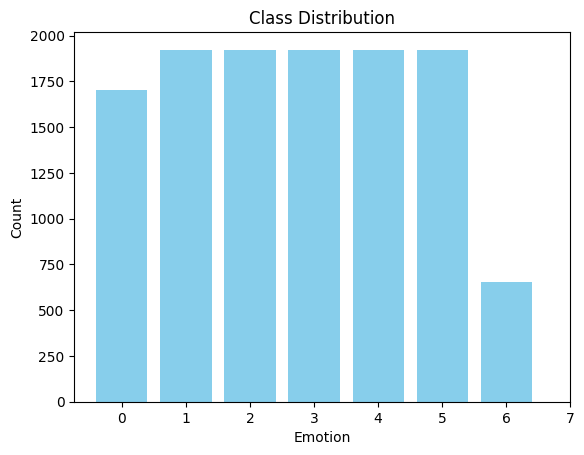

In [81]:
def plot_class_distribution(y):
    #plot the class distribution
    plt.hist(y, bins=range(8), rwidth=0.8, align='left', color='skyblue')
    plt.xticks(range(8))
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()
def plot_spectogram(spec,sr = 22050):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()
plot_class_distribution(df['emotion'])

# Feature extraction

In [82]:
def create_dataset(df, sr=22050, n_mels=128, hop_length=512,augment_data=False):
    """
    Extract feature (logmel, delta, delta2)
    
    Args:
        df: dataframe with path of file and associated emotion
        sr: sampling rate
        n_mels: mels coefficient selected
        hop_length: window overlapping
        augment_data: if True, data augmentation is performed
     
        
    Returns:
        (X, :Extracted feature array [(n_mels, max_len, 3)]
        y   :Associated label array
        )
    """
    def min_max_normalize(X):
        """
        Min max normalize within each channel
        
        Args:
            X: stack of channels
        
            
        Returns:
            X: stack of normalized channels
        """
        for stack in X:
            for c in stack:
                min_value = np.min(c)
                max_value = np.max(c)
                c -= min_value  # Traslare i valori
                if max_value > min_value:  # Evitare divisione per zero
                    c /= (max_value - min_value)  # Normalizzare
        return X
    
    def pad(spectrograms, target_width):
        """
        Aggiunge padding a ciascuno spettrogramma in una lista, considerando i canali (logmel, delta).

        Args:
            spectrograms (list of np.ndarray): Lista di spettrogrammi con forma (n_mels, len, n_channels).
            target_width (int): Larghezza desiderata per gli spettrogrammi.

        Returns:
            list of np.ndarray: Lista di spettrogrammi con padding aggiunto.
        """
        padded_spectrograms = []
        for spectrogram in spectrograms:
            n_mels, original_width, n_channels = spectrogram.shape
            padding_total = target_width - original_width
            
            if padding_total < 0:
                raise ValueError(f"Il target_width ({target_width}) è inferiore alla larghezza originale ({original_width}).")

            padding_left = padding_total // 2
            padding_right = padding_total - padding_left

            padded_spectrogram = np.pad(
                spectrogram,
                pad_width=((0, 0), (padding_left, padding_right), (0, 0)),  # Aggiunge padding solo sull'asse temporale
                mode='constant',
                constant_values=0
            )
            padded_spectrograms.append(padded_spectrogram)

        return padded_spectrograms

    def trim(spectrograms, target_width):
        """
        Taglia o aggiunge padding per ottenere una larghezza target specificata, considerando i canali.

        Args:
            spectrograms (list of np.ndarray): Lista di spettrogrammi con forma (n_mels, len, n_channels).
            target_width (int): Larghezza desiderata per gli spettrogrammi.

        Returns:
            list of np.ndarray: Lista di spettrogrammi aggiustati alla larghezza target.
        """
        trimmed_spectrograms = []
        for spectrogram in spectrograms:
            n_mels, original_width, n_channels = spectrogram.shape

            if original_width < target_width:
                trimmed_spectrogram = pad([spectrogram], target_width)[0]  # Restituisce un array, si prende il primo elemento
            else:
                # Calcola gli indici per il taglio
                start_index = (original_width - target_width) // 2
                end_index = start_index + target_width

                # Taglia la parte centrale
                trimmed_spectrogram = spectrogram[:, start_index:end_index, :]
            
            trimmed_spectrograms.append(trimmed_spectrogram)

        return trimmed_spectrograms




    X = []  # Feature (log-mel spectrograms)
    y = []  # Labels (emotions)

    for row in df.itertuples(index=False):
        path = row.path
        emotion = row.emotion
        audio,_ = librosa.load(path, sr=sr)

        audio_array = []
        audio_array.append(audio)

        if augment_data:
            if emotion == 6:

                #DATA AUGMENTATION
                #speed up
                audio_stretched = librosa.effects.time_stretch(y=audio, rate=1.1)  # speend up by 10%
                #pitch up
                audio_pitched = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=2)  
                # 0.5 time shift
                shift = int(0.5 * sr) 
                audio_shifted = np.roll(audio, shift)
                # noise injection
                noise = np.random.normal(0, 0.05, len(audio))
                audio_noisy = audio + noise 

                #audio_array.append(audio_stretched)
                audio_array.append(audio_pitched)
                #audio_array.append(audio_shifted)
                audio_array.append(audio_noisy)
            
        # Extract features
        for audio in audio_array:
            mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
            log_mel = librosa.power_to_db(mel, ref=np.max)
            
            delta = librosa.feature.delta(log_mel)
            #delta2 = librosa.feature.delta(log_mel, order=2)

            feature = np.stack([log_mel, delta], axis=-1)
      
                    
            #if feature.shape[1] > max_len:
             #   print(feature.shape[1])
              #  max_len = feature.shape[1]
                    
            X.append(feature)
            y.append(emotion)
            
    
    X = min_max_normalize(X)
    X = trim(X, 308)
    print(X[0].shape)
    X = np.array(X)  
    y = np.array(y) 
    return X, y
  

## Train test split

In [83]:
train_indices, test_indices = train_test_split(
    df.index, 
    test_size=0.2, 
    random_state=44
)

train_indices, val_indices = train_test_split(
    train_indices, 
    test_size=0.125,  # 0.125* 0.8 = 10% 
    random_state=44
)

print("Train: ", len(train_indices))
print("Val: ", len(val_indices))
print("Test: ", len(test_indices))

Train:  8379
Val:  1197
Test:  2394


This way of genereting it is done in order to avoid data leakage

In [84]:
X_train, y_train = create_dataset(df.iloc[train_indices], augment_data=False)
X_val, y_val = create_dataset(df.iloc[val_indices], augment_data=False)
X_test, y_test = create_dataset(df.iloc[test_indices], augment_data=False)

(128, 308, 2)
(128, 308, 2)
(128, 308, 2)


In [85]:
len(X_train), len(X_val), len(X_test)   

(8379, 1197, 2394)

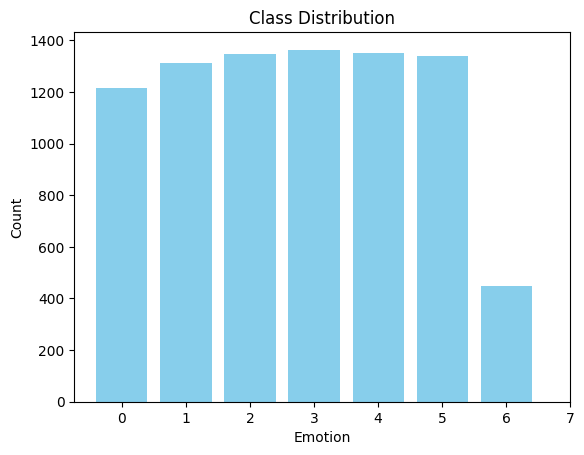

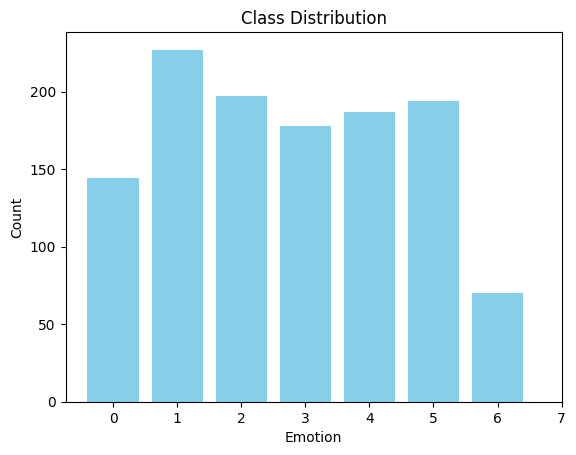

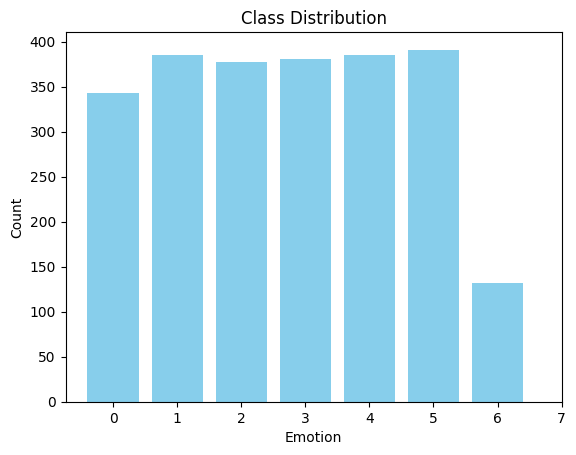

In [86]:
plot_class_distribution(y_train)
plot_class_distribution(y_val)
plot_class_distribution(y_test)

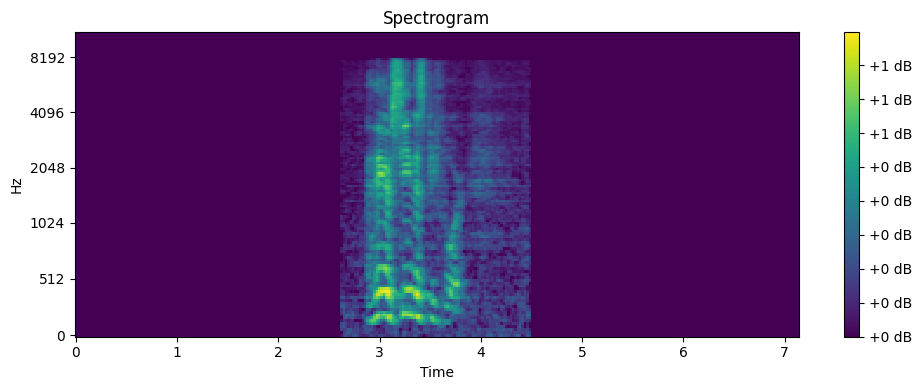

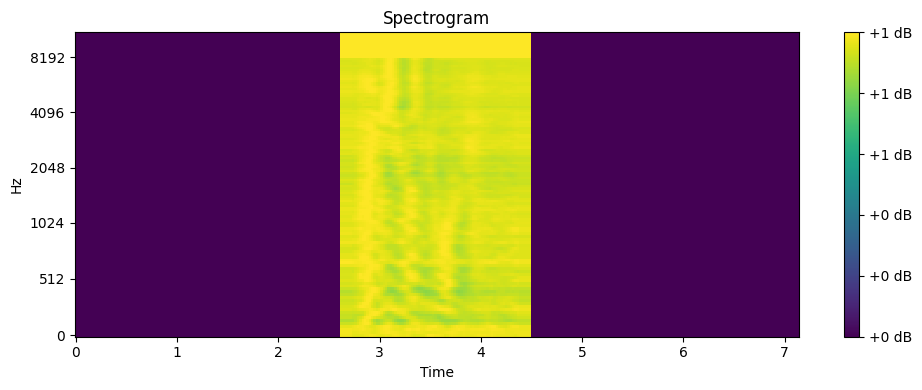

In [87]:
sample = 400
plot_spectogram(X_train[sample][:,:,0])
plot_spectogram(X_train[sample][:,:,1])


# Save dataset

In [88]:
def save_dataset(X_train, X_val, X_test, y_train, y_val, y_test, output_dir="processed_data"):
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "X_train.npy"), X_train)
    np.save(os.path.join(output_dir, "X_val.npy"), X_val)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train)
    np.save(os.path.join(output_dir, "y_val.npy"), y_val)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test)

In [89]:
save_dataset(X_train, X_val, X_test, y_train, y_val, y_test)